<a href="https://colab.research.google.com/github/SahinCatkin/Bootcamp/blob/main/Segmenting_Buildings_In_Satellite_Images_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahinatkn","key":"82c41ed5f9466bed0a326f5e5be6ce2c"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kmader/synthetic-word-ocr

100% 3.92G/3.93G [02:12<00:00, 42.9MB/s]
100% 3.93G/3.93G [02:12<00:00, 31.8MB/s]


In [8]:
!unzip /content/synthetic-word-ocr.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/train/images/000000275742.jpg  
  inflating: train/train/images/000000275743.jpg  
  inflating: train/train/images/000000275744.jpg  
  inflating: train/train/images/000000275745.jpg  
  inflating: train/train/images/000000275746.jpg  
  inflating: train/train/images/000000275747.jpg  
  inflating: train/train/images/000000275748.jpg  
  inflating: train/train/images/000000275749.jpg  
  inflating: train/train/images/000000275750.jpg  
  inflating: train/train/images/000000275751.jpg  
  inflating: train/train/images/000000275752.jpg  
  inflating: train/train/images/000000275753.jpg  
  inflating: train/train/images/000000275754.jpg  
  inflating: train/train/images/000000275755.jpg  
  inflating: train/train/images/000000275756.jpg  
  inflating: train/train/images/000000275757.jpg  
  inflating: train/train/images/000000275758.jpg  
  inflating: train/train/images/000000275759.jpg  
  inflating: train/train/images

In [9]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = '/content/train'
map_img_dir = '/content/train/train/images'

In [10]:
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

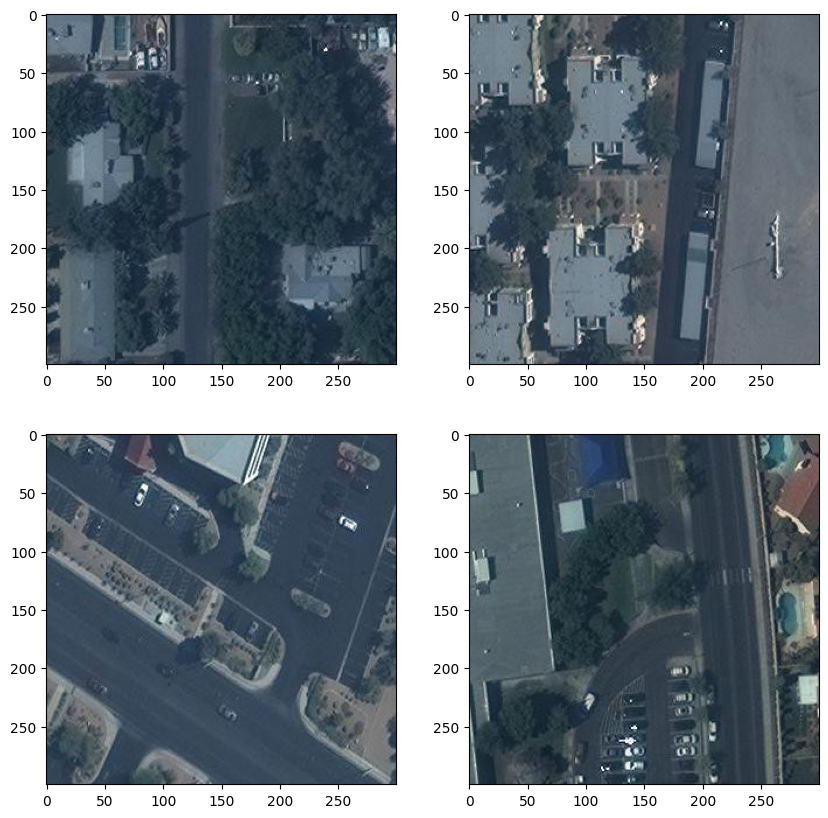

In [11]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [12]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
2323124  1008503    118421  [[20.0, 157.0, 66.0, 163.0, 64.0, 192.0, 80.0,...   
2118458  2151309    252305  [[141.0, 205.0, 119.0, 243.0, 127.0, 250.0, 11...   
1658077    13454      1578  [[21, 59, 41, 76, 35, 81, 52, 95, 25, 115, 0, ...   

           area                        bbox  category_id  iscrowd  
2323124  3709.0   [20.0, 14.0, 174.0, 66.0]          100        0  
2118458  4004.0  [107.0, 68.0, 165.0, 73.0]          100        0  
1658077  1741.0             [0, 0, 115, 52]          100        0

In [13]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
619789   1050450    123372  [[0.0, 56.99999999999999, 36.0, 60.99999999999...   
1670730   983748    115514  [[224.0, 4.531193156845207e-15, 224.0, 21.0000...   

           area                                         bbox  category_id  \
619789   1213.0                       [0.0, 0.0, 88.0, 36.0]          100   
1670730  2768.0  [4.531193156845207e-15, 181.0, 232.0, 51.0]          100   

         iscrowd    id_y         file_name  width  height  
619789         0  123372  000000123372.jpg    300     300  
1670730        0  115514  000000115514.jpg    300     300

In [14]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

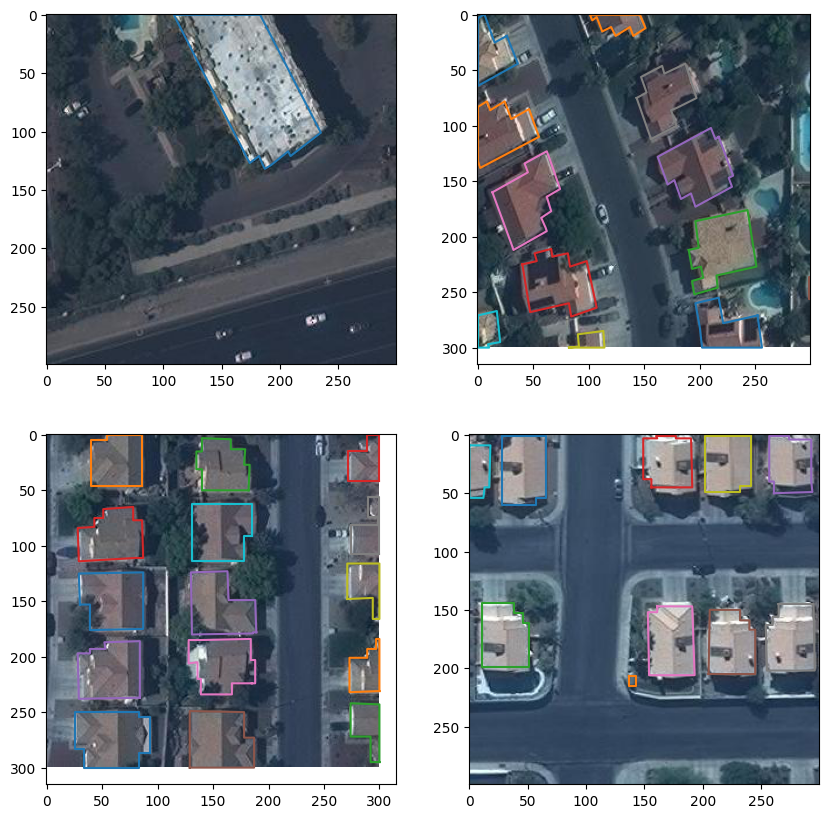

In [15]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [16]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

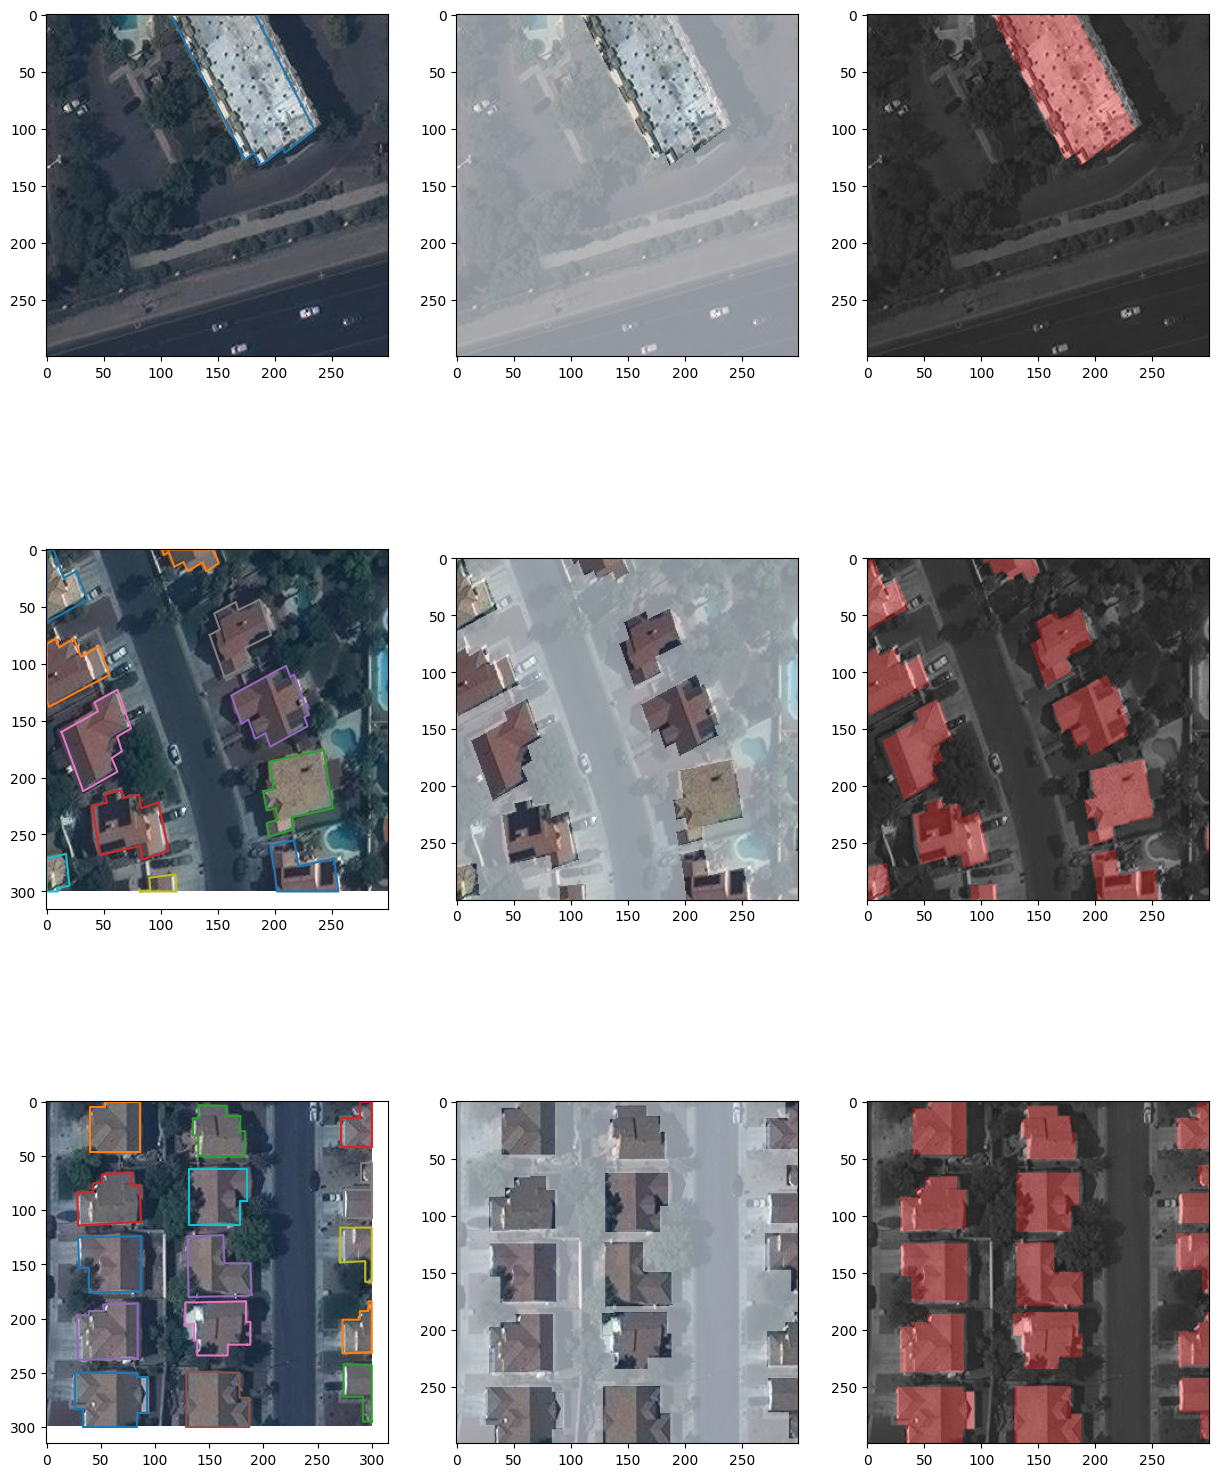

In [17]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [18]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1798265 training boxes
597288 validation boxes


In [19]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)        

In [20]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from skimage.util import montage as montage2d

<ipython-input-19-2c0ef8c83e8d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


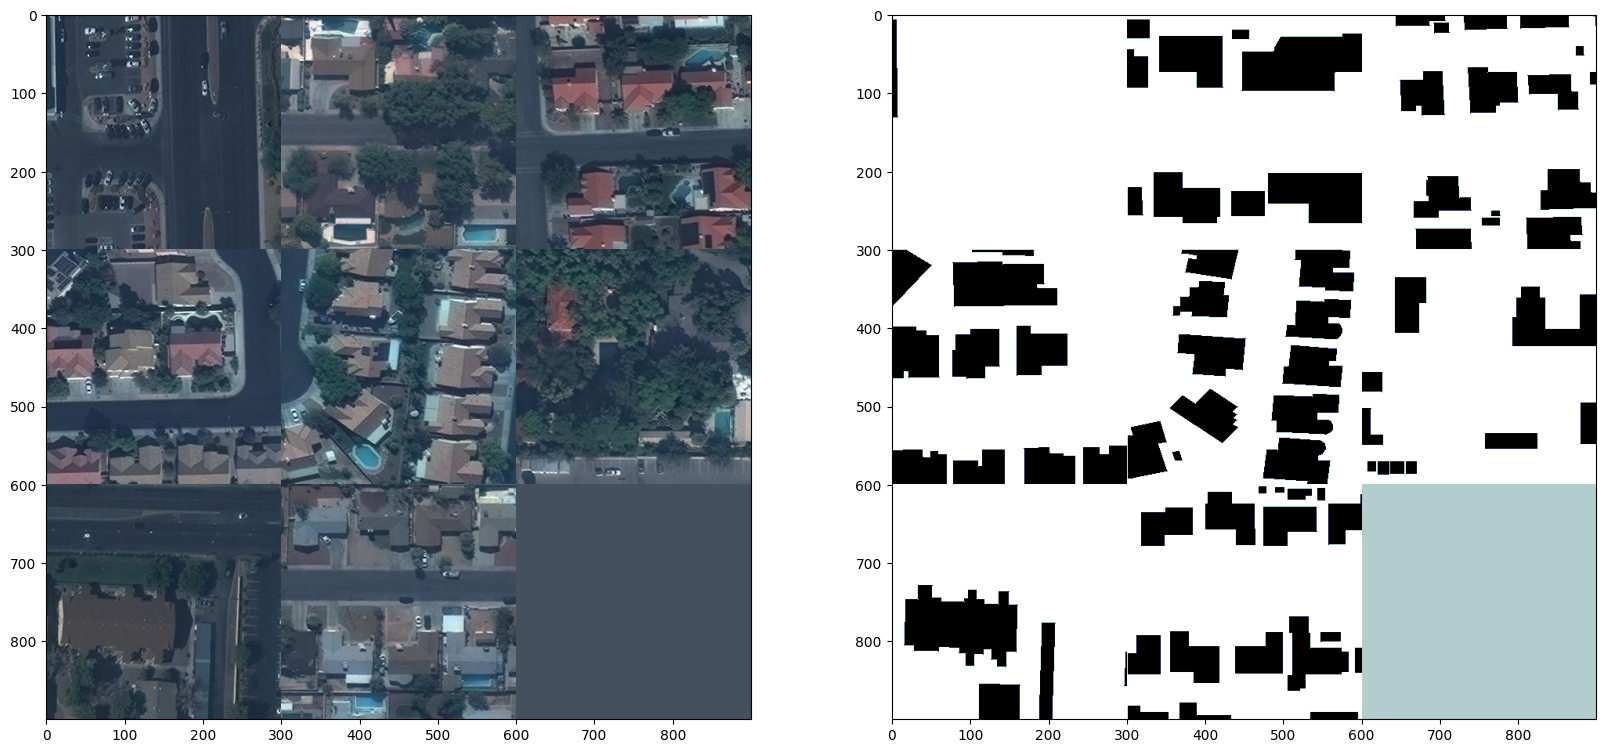

In [22]:
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [23]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [24]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 300, 300, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              

In [25]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [26]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [28]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=2, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                             use_multiprocessing=True,
                            workers=2)]

<ipython-input-19-2c0ef8c83e8d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: -0.3564 - dice_coef: 0.4276 - binary_accuracy: 0.6839 - true_positive_rate: 0.6640

<ipython-input-19-2c0ef8c83e8d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):



Epoch 1: val_dice_coef improved from -inf to 0.42608, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 96s 966ms/step - loss: -0.3564 - dice_coef: 0.4276 - binary_accuracy: 0.6839 - true_positive_rate: 0.6640 - val_loss: -0.3529 - val_dice_coef: 0.4261 - val_binary_accuracy: 0.6547 - val_true_positive_rate: 0.7327 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: -0.3999 - dice_coef: 0.4779 - binary_accuracy: 0.7263 - true_positive_rate: 0.6751
Epoch 2: val_dice_coef improved from 0.42608 to 0.47318, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 80s 806ms/step - loss: -0.3999 - dice_coef: 0.4779 - binary_accuracy: 0.7263 - true_positive_rate: 0.6751 - val_loss: -0.4082 - val_dice_coef: 0.4732 - val_binary_accuracy: 0.7624 - val_true_positive_rate: 0.6046 - lr: 1.0000e-04


In [29]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 1s 1s/step


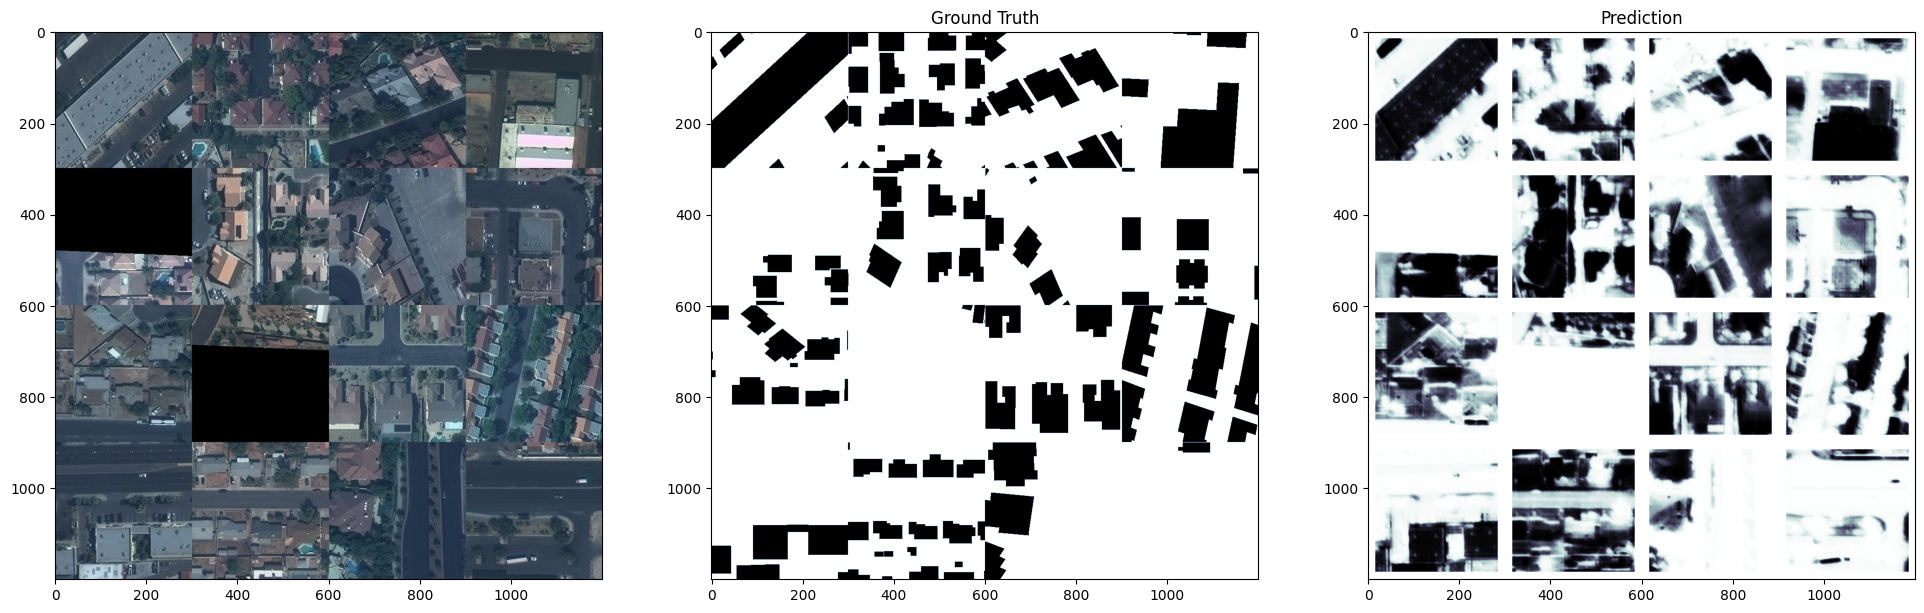

In [30]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

In [31]:
def single_img_gen(c_df):
    """
    function to get a single image from a part of a dataframe
    """
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    out_seg = np.expand_dims(rows_to_segmentation(img_data, c_df), -1)
    return (img_data/255.0).astype(np.float32), out_seg.astype(np.float32) 

x (300, 300, 3) float32 0.05882353 1.0
y (300, 300, 1) float32 0.0 1.0


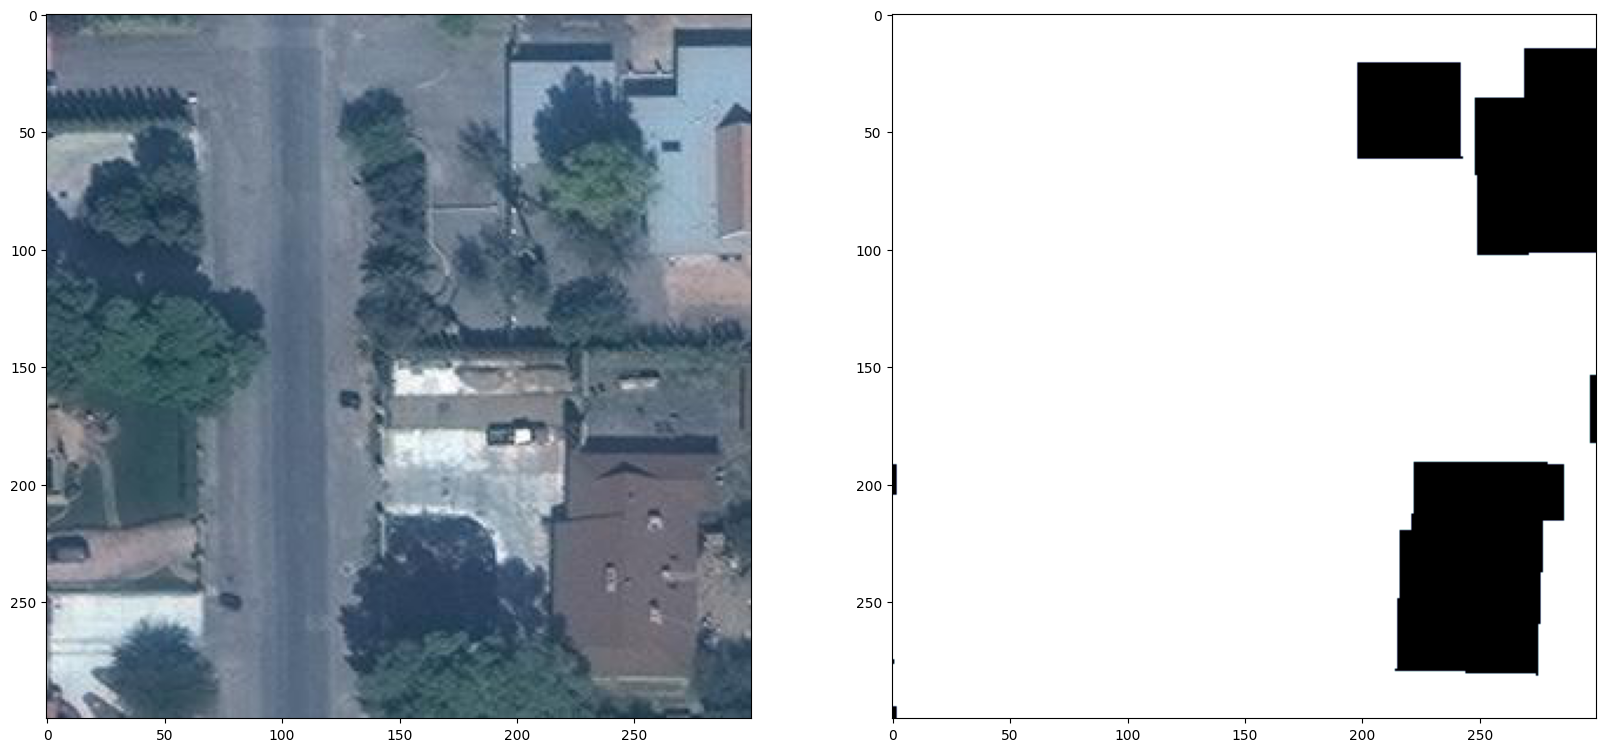

In [33]:
from skimage.util import montage as montage2d
single_df = valid_df[valid_df['image_id'].isin([valid_df['image_id'].values[0]])]
t_x, t_y = single_img_gen(single_df)   
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(t_x)
ax2.imshow(t_y[:, :, 0], cmap = 'bone_r')

In [34]:
import dask.array as da
import dask
import dask.diagnostics as diag
from multiprocessing.pool import ThreadPool
import h5py
from bokeh.io import output_notebook
from bokeh.resources import CDN
output_notebook(CDN, hide_banner=True)

In [35]:
@dask.delayed
def dgen_as_alpha(in_df):
    x, y = single_img_gen(in_df)
    return np.concatenate([x, y], -1)

def dask_read_seg(in_df, max_items = 1000):
    lazy_images = [dgen_as_alpha(c_df.copy()) for _, (_, c_df) in zip(range(max_items), 
                                                          in_df.groupby('image_id'))
                  ]     # Lazily evaluate on each group
    s_img = lazy_images[0].compute()
    arrays = [da.from_delayed(lazy_image,           # Construct a small Dask array
                              dtype=s_img.dtype,   # for every lazy value
                              shape=s_img.shape)
              for lazy_image in lazy_images]

    return da.stack(arrays, axis=0)

In [36]:
big_chunker = lambda x: x.rechunk({0: x.shape[0]//32, 1: -1, 2: -1, 3: -1})

In [37]:
train_array = big_chunker(dask_read_seg(train_df, 750))
print(train_array)

dask.array<rechunk-merge, shape=(750, 300, 300, 4), dtype=float32, chunksize=(23, 300, 300, 4), chunktype=numpy.ndarray>


In [38]:
valid_array = big_chunker(dask_read_seg(valid_df, 250))
print(valid_array)

dask.array<rechunk-merge, shape=(250, 300, 300, 4), dtype=float32, chunksize=(7, 300, 300, 4), chunktype=numpy.ndarray>


In [39]:
!rm *.h5

In [40]:
with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    with dask.config.set(pool=ThreadPool(4)):
        train_array.to_hdf5('train.h5', '/images', compression = 'lzf')
        valid_array.to_hdf5('valid.h5', '/images', compression = 'lzf')
!ls -lh *.h5

[########################################] | 100% Completed | 29.27 s
[########################################] | 100% Completed | 9.71 s
-rw-r--r-- 1 root root 361M May 26 14:57 train.h5
-rw-r--r-- 1 root root 120M May 26 14:57 valid.h5


In [41]:
@dask.delayed
def dgen_just_seg(in_df):
    _, y = single_img_gen(in_df)
    return y.astype(bool) # much smaller

def dask_read_just_seg(in_df, max_items = 1000):
    lazy_images = [(c_id, dgen_just_seg(c_df.copy())) for _, (c_id, c_df) in zip(range(max_items), 
                                                          in_df.groupby('image_id'))
                  ]     # Lazily evaluate on each group
    s_img = lazy_images[0][1].compute()
    arrays = [da.from_delayed(lazy_image,           # Construct a small Dask array
                              dtype=s_img.dtype,   # for every lazy value
                              shape=s_img.shape)
              for _, lazy_image in lazy_images]
    img_ids = [c_id for c_id, _ in lazy_images]

    return img_ids, da.stack(arrays, axis=0)

In [42]:
all_ids, all_array = dask_read_just_seg(full_df, 10000)
print(all_array)

dask.array<stack, shape=(10000, 300, 300, 1), dtype=bool, chunksize=(1, 300, 300, 1), chunktype=numpy.ndarray>


In [43]:
with open('all_segmentations.json', 'w') as f:
    json.dump({'image_id': all_ids}, f)

In [44]:
big_chunker = lambda x: x.rechunk({0: x.shape[0]//128, 1: -1, 2: -1, 3: -1})
all_array = big_chunker(all_array)
all_array

dask.array<rechunk-merge, shape=(10000, 300, 300, 1), dtype=bool, chunksize=(78, 300, 300, 1), chunktype=numpy.ndarray>

In [45]:
with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    with dask.config.set(pool=ThreadPool(4)):
        all_array.to_hdf5('all_segmentations.h5', '/images', 
                          compression = 'lzf')
!ls -lh *.h5

[########################################] | 100% Completed | 373.61 s
-rw-r--r-- 1 root root  39M May 26 15:05 all_segmentations.h5
-rw-r--r-- 1 root root 361M May 26 14:57 train.h5
-rw-r--r-- 1 root root 120M May 26 14:57 valid.h5


In [46]:
diag.visualize([prof, rprof])

Column(id='1140', ...)